In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
indexData = pd.read_csv('../data/indexData_webbase.txt', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'EWAH_bitmap_Bytes', 'Bitmap_1s']
indexData.columns = header

In [4]:
indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,EWAH_bitmap_Bytes,Bitmap_1s,Bitmap_Bytes,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co
0,2490722,2024405,10.698,466317,202008,77788,209748,2024405,311341.250,9962888,1865268,808032,311152,0.919,0.833,0.782,0.948
1,915500,563926,5.205,351574,116035,66355,101176,563926,114438.500,3662000,1406296,464140,265420,0.873,0.811,0.585,0.900
2,1138505,657931,4.614,480574,140061,85173,123948,657931,142314.125,4554020,1922296,560244,340692,0.877,0.823,0.547,0.898
3,34542,24129,11.197,10413,5220,3463,3568,24129,4318.750,138168,41652,20880,13852,0.849,0.667,0.667,0.874
4,1492,839,2.975,653,252,137,192,839,187.500,5968,2612,1008,548,0.831,0.790,0.531,0.876
5,29,1,1.000,28,15,15,8,1,4.625,116,112,60,60,0.483,0.464,-0.005,0.414
6,4,2,2.000,2,3,3,8,2,1.500,16,8,12,12,0.250,-0.500,0.406,-0.250
7,4,2,2.000,2,3,3,8,2,1.500,16,8,12,12,0.250,-0.500,0.406,-0.250
8,225,47,1.237,178,79,67,36,47,29.125,900,712,316,268,0.649,0.624,0.177,0.662
9,4,2,2.000,2,3,3,8,2,1.500,16,8,12,12,0.250,-0.500,0.406,-0.250


In [6]:
# Size of vocabulary: 14813510 (terms) #
# 2134281 / 14813510 = 0.144076657 #
indexData[indexData.columns[9:]].describe()

,Bitmap_Bytes,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co
count,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000,2134281.000
mean,167.402,5324.862,2358.851,909.008,651.827,0.326,0.120,0.220,0.159
std,4090.416,130893.301,39312.353,13268.505,7625.407,0.332,0.522,0.206,0.535
min,1.250,8.000,4.000,8.000,8.000,-0.500,-1.000,-0.030,-1.000
25%,1.625,20.000,12.000,16.000,12.000,0.200,0.000,0.062,-0.167
50%,3.000,64.000,44.000,36.000,28.000,0.420,0.333,0.156,0.333
75%,8.250,232.000,180.000,100.000,88.000,0.551,0.500,0.344,0.544
max,826146.500,26436656.000,3736772.000,1372912.000,517940.000,0.962,0.916,0.968,0.999


In [7]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		33.73
[0.1, 0.2)	0.00		6.52
[0.2, 0.3)	0.00		5.93
[0.3, 0.4)	0.10		9.11
[0.4, 0.5)	1.13		11.39
[0.5, 0.6)	3.98		10.27
[0.6, 0.7)	5.49		3.75
[0.7, 0.8)	3.90		0.31
[0.8, 0.9)	3.31		0.03
[0.9, 1.0)	1.06		0.00
Total		18.97		81.03


In [8]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	32.84
[0.1, 0.2)	18.91
[0.2, 0.3)	12.08
[0.3, 0.4)	15.66
[0.4, 0.5)	5.50
[0.5, 0.6)	3.97
[0.6, 0.7)	2.10
[0.7, 0.8)	1.86
[0.8, 0.9)	1.39
[0.9, 1.0)	1.08
Total		95.39


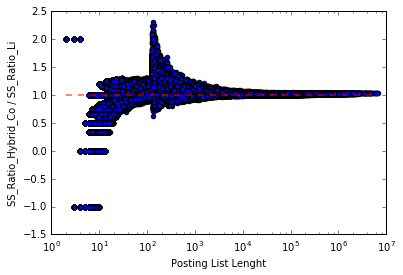

In [9]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

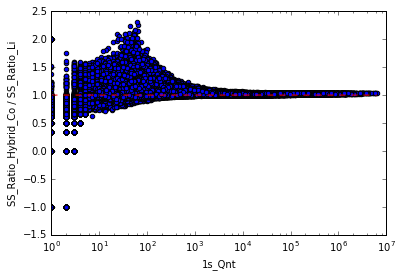

In [10]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

(0.0, 1.1)

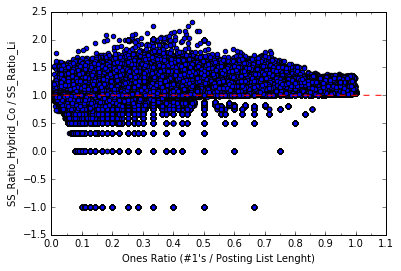

In [11]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)
onesRatio = indexData['1s_Qnt'] / indexData['Li_Len']

figure, ax = plt.subplots()
ax.scatter(onesRatio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])